##**Transfer Learning VS Training from Scratch**




## Load Library and Preprocessing step
I am using CIFAR-10 Dataset

In [ ]:
#Load libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout,Conv2D
from tensorflow.image import resize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

In [ ]:
#Load and preprocess
(x_train, y_train), (x_test, y_test)=datasets.cifar10.load_data()
#x_train, x_test = x_train /255.0, x_test /255.0
x_train =tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)
y_train= tf.keras.utils.to_categorical(y_train,10)
y_test= tf.keras.utils.to_categorical(y_test,10)

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
# Parameters
sample_number = x_train.shape[0]
img_w =x_train.shape[1]
img_h = x_train.shape[2]
img_channel = x_train.shape[3]
resnet_input_dim = (224,224)

## Pretrained model (ResNet50)
Setup ResNet50 and freez 143 first layer(All layers except last block)

In [ ]:
# Create pretrained model  - include_top = False >> No Fully connected layer
pretrained_model = ResNet50(include_top=False,
                            weights='imagenet')
freeze_number = 143
for layer in pretrained_model.layers[:freeze_number]:
  layer.trainable = False

##Create customized model(ResNet50(Base) + Customized layers (Head))

In [ ]:
customized_model = Sequential()
customized_model.add(tf.keras.layers.Lambda(lambda image:resize(image, resnet_input_dim)))
customized_model.add(pretrained_model)
customized_model.add(Conv2D(128, (3,3), strides=(1, 1),activation='relu'))
customized_model.add(Flatten())
customized_model.add(BatchNormalization())
customized_model.add(Dense(256, activation='relu'))
customized_model.add(Dropout(0.5))
customized_model.add(BatchNormalization())
customized_model.add(Dense(128, activation='relu'))
customized_model.add(Dropout(0.5))
customized_model.add(BatchNormalization())
customized_model.add(Dense(64, activation='relu'))
customized_model.add(Dropout(0.5))
customized_model.add(BatchNormalization())
customized_model.add(Dense(10, activation='softmax'))


##Compileing and Fitting Step

In [ ]:
customized_model.compile(loss='categorical_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])
customized_callbacks = [EarlyStopping(monitor='accuracy',patience=3,mode='max', verbose=1),
                        ModelCheckpoint('/data/',monitor='val_accuracy', save_best_only=True, mode='max',verbose=0)]
history = customized_model.fit(x_train,
                               y_train,
                               batch_size=32,
                               epochs=5,
                               verbose=1,
                               validation_data=(x_test, y_test),
                               callbacks=[customized_callbacks])


Epoch 1/5
1563/1563 [==============================] - 252s 159ms/step - loss: 0.5124 - accuracy: 0.8622 - val_loss: 0.2557 - val_accuracy: 0.9191
INFO:tensorflow:Assets written to: /data/assets
Epoch 2/5
1563/1563 [==============================] - 248s 158ms/step - loss: 0.3564 - accuracy: 0.9034 - val_loss: 0.2369 - val_accuracy: 0.9258
INFO:tensorflow:Assets written to: /data/assets
Epoch 3/5
1563/1563 [==============================] - 245s 157ms/step - loss: 0.2597 - accuracy: 0.9325 - val_loss: 0.2645 - val_accuracy: 0.9198
Epoch 4/5
1563/1563 [==============================] - 247s 158ms/step - loss: 0.2066 - accuracy: 0.9472 - val_loss: 0.2418 - val_accuracy: 0.9265
INFO:tensorflow:Assets written to: /data/assets
Epoch 5/5
1563/1563 [==============================] - 245s 157ms/step - loss: 0.1673 - accuracy: 0.9558 - val_loss: 0.2426 - val_accuracy: 0.9356
INFO:tensorflow:Assets written to: /data/assets


##Plotting Accuracy and Calculating Average of 3 runs

In [ ]:
customized_model.save('customized.model')

INFO:tensorflow:Assets written to: customized.model/assets


Training Accuracy Average for Pretrained DCNN 0.9008200168609619
Testing Accuracy Average for Pretrained DCNN 0.9008200168609619


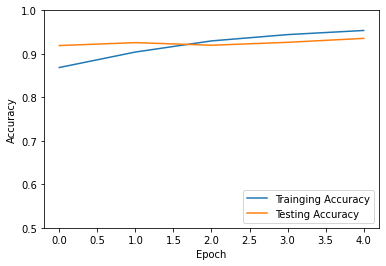

In [ ]:
plt.plot(history.history['accuracy'], label='Trainging Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#test_loss, test_acc = customized_model.evaluate(x_test,  y_test, verbose=2)

sum_train_acc = 0
sum_test_acc = 0
epoch_num = 3
for epoch in range(epoch_num):
  sum_train_acc += history.history['accuracy'][epoch]
  sum_test_acc += history.history['val_accuracy'][epoch]

avg_train_acc = (sum_train_acc / epoch_num)
avg_test_acc = (sum_train_acc / epoch_num)

print('Training Accuracy Average for Pretrained DCNN',avg_train_acc)
print('Testing Accuracy Average for Pretrained DCNN',avg_test_acc)


##Train DCNN From Scratch




In [ ]:
res_model = ResNet50(include_top=False,
                     weights=None,
                     pooling='avg',
                     input_shape =(img_w,img_h,img_channel))
random_w_model = Sequential()
random_w_model.add(res_model)
random_w_model.add(Dense(10, activation='softmax'))

In [ ]:
random_w_model.compile(loss='categorical_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])
customized_callbacks_scratch = [EarlyStopping(monitor='accuracy',patience=3,mode='max', verbose=1),
                        ModelCheckpoint('/data/',monitor='val_accuracy', save_best_only=True, mode='max',verbose=0)]
history_r = random_w_model.fit(x_train,
                               y_train,
                               batch_size=32,
                               epochs=100,
                               verbose=1,
                               validation_data=(x_test, y_test),
                               callbacks=[customized_callbacks_scratch])
random_w_model.save('random_w_model.model')

Epoch 1/100
1563/1563 [==============================] - 72s 43ms/step - loss: 2.3606 - accuracy: 0.2529 - val_loss: 2.1822 - val_accuracy: 0.2400
INFO:tensorflow:Assets written to: /data/assets
Epoch 2/100
1563/1563 [==============================] - 66s 42ms/step - loss: 2.2930 - accuracy: 0.2483 - val_loss: 1.9881 - val_accuracy: 0.2870
INFO:tensorflow:Assets written to: /data/assets
Epoch 3/100
1563/1563 [==============================] - 66s 42ms/step - loss: 2.1003 - accuracy: 0.3228 - val_loss: 4.5527 - val_accuracy: 0.2351
Epoch 4/100
1563/1563 [==============================] - 65s 42ms/step - loss: 2.1364 - accuracy: 0.2846 - val_loss: 2.7746 - val_accuracy: 0.2978
INFO:tensorflow:Assets written to: /data/assets
Epoch 5/100
1563/1563 [==============================] - 66s 42ms/step - loss: 1.9463 - accuracy: 0.3477 - val_loss: 2.9440 - val_accuracy: 0.3031
INFO:tensorflow:Assets written to: /data/assets
Epoch 6/100
1563/1563 [==============================] - 65s 42ms/step - 

In [ ]:

sum_train_acc_rw = 0
sum_test_acc_rw = 0

epoch_num = 34
for epoch in range(epoch_num):
  sum_train_acc_rw += history_r.history['accuracy'][epoch]
  sum_test_acc_rw += history_r.history['val_accuracy'][epoch]

avg_train_acc = (sum_train_acc_rw / epoch_num)
avg_test_acc = (sum_train_acc_rw / epoch_num)
print('Training Accuracy Average for Pretrained DCNN',avg_train_acc)
print('Testing Accuracy Average for Pretrained DCNN',avg_test_acc)


Training Accuracy Average for Pretrained DCNN 0.6866182347430902
Testing Accuracy Average for Pretrained DCNN 0.6866182347430902


##Train DCNN From Scratch - CUSTOMIZED


In [ ]:
r_model = ResNet50(include_top=False,
                     weights=None,
                     pooling='avg',
                     )
my_model = Sequential()

my_model.add(tf.keras.layers.Lambda(lambda image:resize(image, resnet_input_dim)))
my_model.add(r_model)

my_model.add(Flatten())
my_model.add(BatchNormalization())
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(BatchNormalization())
my_model.add(Dense(128, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(BatchNormalization())
my_model.add(Dense(64, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(BatchNormalization())
my_model.add(Dense(10, activation='softmax'))


In [ ]:
my_model.compile(loss='categorical_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])
my_callbacks = [EarlyStopping(monitor='accuracy',patience=3,mode='max', verbose=1),
                        ModelCheckpoint('/data/',monitor='val_accuracy', save_best_only=True, mode='max',verbose=0)]
my_history = my_model.fit(x_train,
                               y_train,
                               batch_size=32,
                               epochs=30,
                               verbose=1,
                               validation_data=(x_test, y_test),
                               callbacks=[my_callbacks])

Epoch 1/30
1563/1563 [==============================] - 520s 329ms/step - loss: 2.3454 - accuracy: 0.1634 - val_loss: 3.2141 - val_accuracy: 0.1618
INFO:tensorflow:Assets written to: /data/assets
Epoch 2/30
1563/1563 [==============================] - 512s 328ms/step - loss: 1.8696 - accuracy: 0.2796 - val_loss: 1.6478 - val_accuracy: 0.3601
INFO:tensorflow:Assets written to: /data/assets
Epoch 3/30
1563/1563 [==============================] - 513s 328ms/step - loss: 1.6697 - accuracy: 0.3620 - val_loss: 1.4600 - val_accuracy: 0.4414
INFO:tensorflow:Assets written to: /data/assets
Epoch 4/30
1563/1563 [==============================] - 514s 329ms/step - loss: 1.4681 - accuracy: 0.4596 - val_loss: 1.3259 - val_accuracy: 0.5053
INFO:tensorflow:Assets written to: /data/assets
Epoch 5/30
1563/1563 [==============================] - 513s 328ms/step - loss: 1.2982 - accuracy: 0.5380 - val_loss: 1.1595 - val_accuracy: 0.5680
INFO:tensorflow:Assets written to: /data/assets
Epoch 6/30
1563/1563

**Question** Compare the performance gab and training time between the above two conditions. Please explain why you obtained such results, and give a brief discussion about it. Based on the paper (Rethinking ImageNet Pre-training, ICCV,2019), the ImageNet pretrained model does not improve accuracy unless the target dataset is too small. Did your experimental result support the conclusion?

**Question**
compare the performance gab and training time between your results (training from scratch) and your results in the Home Assignment 2 Part I. Explain why you obtained such results, and give a brief discussion of why the results are different. (hint: Equation (21) in the slides in Week3).